## Clustering and Dimensionality on World COVID-19 Data

### Requirements:
* pandas
* sklearn
* pydantic
* requests
* covid
* matplotlib
* numpy

May need to install each module with following command:
sudo python3 -m pip install *module_name*
Covid Data from https://github.com/ahmednafies/covid

In [3]:

from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

from covid import Covid
# to get data from worldometers.info
covid = Covid(source="worldometers")


In [4]:
# example of some commands that can be run on data
active = covid.get_total_active_cases()

confirmed = covid.get_total_confirmed_cases()

recovered = covid.get_total_recovered()

deaths = covid.get_total_deaths()

# see current number of deaths 
print(deaths)

581221


#### Now we have the data, we want to read it as a data frame so we can perform clustering and dimensionality reduction algorithms

We set the 'country' as the index, so that each row has only numeric data and is identified by the country. \

We don't want to include new_cases and new_deaths data, as these vary depending on time of day code is run. We also want to only gather data for countries, not continents. 

In [5]:
covid_df = pd.DataFrame(covid.get_data())



# we don't want world or continent data
covid_df = covid_df.set_index('country')
covid_df.drop(columns=['new_cases', 'new_deaths'], inplace=True)
covid_df.drop(['Asia', 'Africa', 'North America', 'South America', 'Europe', 'Oceania', 'World', '0'], axis=0, inplace=True)

# preview data
print(covid_df.head())

         confirmed  deaths  recovered   active  critical  total_tests  \
country                                                                 
USA        3545077  139143    1600195  1805739     16337     44030877   
Brazil     1931204   74262    1213512   643430      8318      4572796   
India       937487   24315     593080   320092      8944     12092503   
Russia      739947   11614     512825   215508      2300     23495752   
Peru        333867   12229     223261    98377      1325      1963921   

        total_tests_per_million total_cases_per_million  \
country                                                   
USA                           0                   10708   
Brazil                        0                    9083   
India                         0                     679   
Russia                        0                    5070   
Peru                          0                   10121   

        total_deaths_per_million  population  
country                    

#### Dimensionality reduction with PCA

We want to represent the COVID data of each country in a two-dimensional space. Currently, each country has 13 features, such as deaths, recovered etc. We will use a PCA implementation by python's sklearn module. 

This follow tutorial found at https://www.codementor.io/@jadianes/data-science-python-pandas-r-dimensionality-reduction-du1081aka


In [6]:
pca = PCA(n_components=2)

pca.fit(covid_df)

covid_2d = pca.transform(covid_df)

covid_df_2d = pd.DataFrame(covid_2d)

covid_df_2d.index = covid_df.index

covid_df_2d.columns = ['PC1','PC2']

covid_df_2d.head()

print(pca.explained_variance_ratio_) 

[0.99887894 0.00111604]


#### Now we can Plot the Lower Dimensional Representation of our data

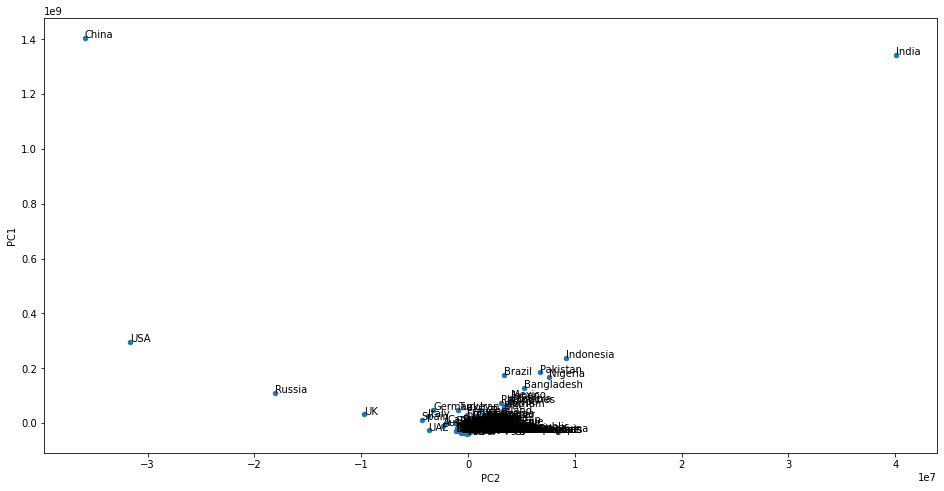

In [7]:
%matplotlib inline
    
ax = covid_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))
    
for i, country in enumerate(covid_df.index):
    ax.annotate(
        country, 
        (covid_df_2d.iloc[i].PC2, covid_df_2d.iloc[i].PC1)
    )

In [99]:
# Optionally Check outliers

# print(covid_df.loc['USA'])
# print(covid_df.loc['India'])
# print(covid_df.loc['China'])
# print(covid_df.loc['Italy'])

#### Now, we can plot a bubble chart with data point size proportional to total number of cases of that country.

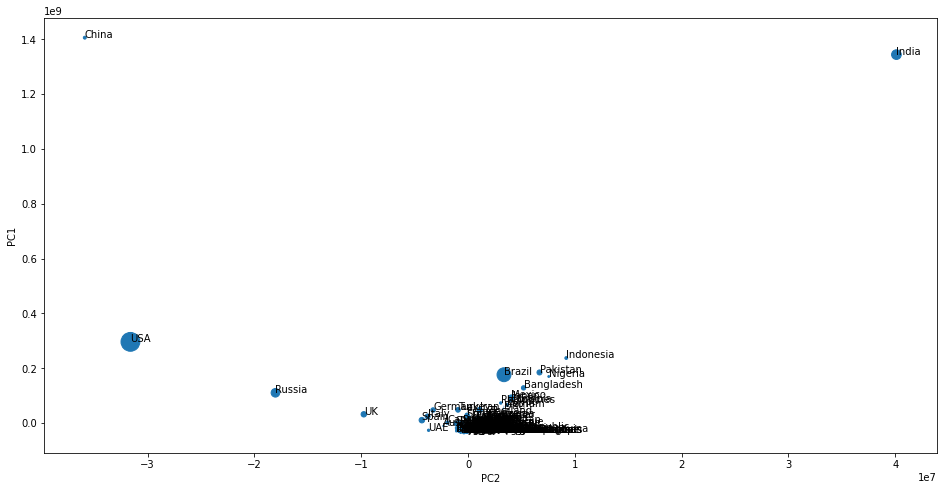

In [8]:
covid_df_2d.head()

covid_df_2d['confirmed'] = covid_df['confirmed']

bubble = covid_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=covid_df_2d['confirmed']/10000, figsize=(16,8))
    
for i, country in enumerate(covid_df.index):
    bubble.annotate(
        country, 
        (covid_df_2d.iloc[i].PC2, covid_df_2d.iloc[i].PC1)
    )

### Now, we want to use Cluster countries according to COVID and use that on our plots to see any potential insight or patterns

We will use k-means clustering with different values of k to see which is optimal. 

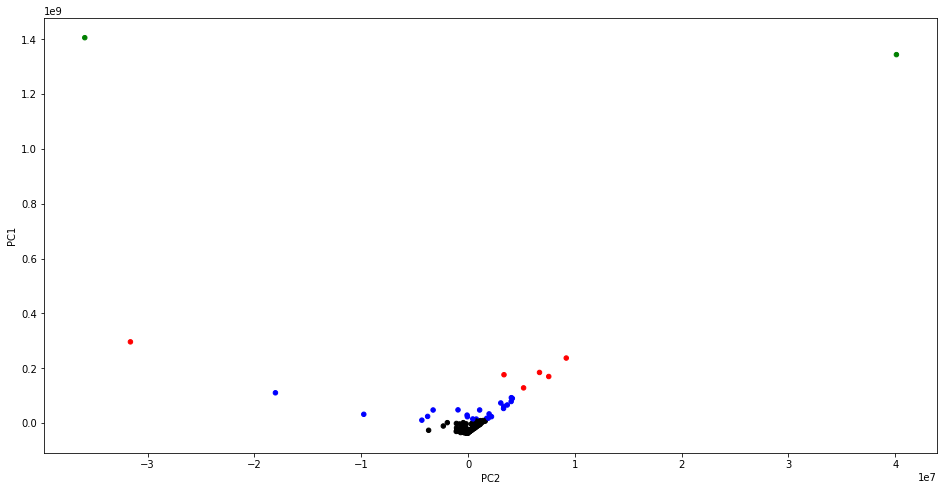

In [27]:
kmeans_performance = []
min_clusters = 4
max_clusters = 8

for k in range(min_clusters, max_clusters):
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit(covid_df)
    kmeans_performance.append(kmeans.inertia_)
    
# add min_clusters to offset 0-indexing
optimal_k = min_clusters + kmeans_performance.index(max(kmeans_performance))

# re-create optimal kmeans clustering and plot
kmeans_best = KMeans(n_clusters=optimal_k)
clusters = kmeans_best.fit(covid_df)
covid_df_2d['cluster'] = pd.Series(clusters.labels_, index=covid_df_2d.index)

# Map clusters to colors instead of grayscale
covid_df_2d.cluster = covid_df_2d.cluster.map({0:'k', 1: 'g', 2: 'b', 3:'r', 4:'m', 5:'c', 6:'y', 7:'w'})

covid_df_2d.plot(kind='scatter',x='PC2',y='PC1', c=covid_df_2d.cluster, figsize=(16,8))